In [1]:
using Revise
using Pkg
TAMBO_PATH = "/Users/jlazar/research/TAMBO-MC/Tambo/"
Pkg.activate(TAMBO_PATH)
using Tambo

using StatsBase
using Distributions

using JLD2

include("../figures/paperstyle.jl")

  Activating project at `~/research/TAMBO-MC/Tambo`


no_bg_dark! (generic function with 1 method)

In [2]:
const zmin = -1100units.m
const zmax = 1100units.m
const upgoing_sim = jldopen("/Users/jlazar/Downloads/Oct16th2023_WhitePaper_300k.jld2")
const downgoing_sim = jldopen("/Users/jlazar/Downloads/Feb1st2024_downgoing_500k.jld2")
const lowe_sim = jldopen("/Users/jlazar/Downloads/Feb2nd2024_lowE_100k.jld2")
const config = SimulationConfig(tambo_coordinates=whitepaper_coord, θmax=π/2)
const geo = Tambo.Geometry(config)
const plane = Tambo.Plane(whitepaper_normal_vec, whitepaper_coord, geo)
const injector = Tambo.Injector(config)

DATA_DIR = "./output/"

γ = 2.37
norm = 1.44e-18 / units.GeV / units.cm^2 / units.second * (1 /(100units.TeV))^-γ
pl = Tambo.PowerLaw(γ, 100units.GeV, 1e9units.GeV, norm)

PowerLaw(γ=2.37, emin=100.0 GeV, emax=1.0e9 GeV)

In [59]:
ℓ = 10_000 * units.m
Δs = 100 * units.m
modules = Tambo.make_trianglearray(-2000units.m, 3000units.m, -ℓ / 2, ℓ / 2, Δs, ϕ=whitepaper_normal_vec.ϕ)
modules = filter((m,) -> zmin < Tambo.plane_z(m.x, m.y, plane) < zmax, modules);

In [4]:
downgoing_event_dicts = jldopen("$(DATA_DIR)/20240201_event_dicts_merged.jld2")
upgoing_event_dicts = jldopen("$(DATA_DIR)/20231231_event_dicts_merged.jld2")
lowe_event_dicts = jldopen("$(DATA_DIR)/20240202_event_dicts_merged.jld2");

In [5]:
function event_weight(event::Tambo.CorsikaEvent)
    weight = event.weight
    if weight > 1 # This is a weighted particle and needs to be sampled
        weight = rand(Poisson(weight))
    end
    return Int(weight)
end

event_weight (generic function with 1 method)

In [6]:
function has_triggered(
    hits_dict::Dict{Int, Vector{Tambo.CorsikaEvent}};
    local_threshhold=3,
    global_threshhold=30,
    sensor_threshold=3
)
    nhits = 0
    nsensors = 0
    for events in values(hits_dict)
        weights = event_weight.(events)
        
        if sum(weights) < local_threshhold
            continue
        end
        
        nsensors += 1
        nhits += sum(weights)
        if nhits >= global_threshhold && nsensors >= sensor_threshold
            return true
        end
    end

    return false
end

has_triggered (generic function with 1 method)

In [7]:
sims = [upgoing_sim, downgoing_sim, lowe_sim]
event_dicts = [
    upgoing_event_dicts["20231231/1000_150"],
    downgoing_event_dicts["20240201/1000_150"],
    lowe_event_dicts["20240202/1000_150"]
]

3-element Vector{JLD2.Group{JLD2.JLDFile{JLD2.MmapIO}}}:
 JLD2.Group
 ├─🔢 138
 ├─🔢 949
 ├─🔢 1829
 ├─🔢 2730
 ├─🔢 3900
 ├─🔢 4727
 ├─🔢 5686
 ├─🔢 6683
 ├─🔢 7882
 └─ ⋯ (3773 more entries)
 JLD2.Group
 ├─🔢 987
 ├─🔢 5938
 ├─🔢 10580
 ├─🔢 15903
 ├─🔢 20171
 ├─🔢 25838
 ├─🔢 30337
 ├─🔢 35006
 ├─🔢 39987
 └─ ⋯ (4811 more entries)
 JLD2.Group
 ├─🔢 338
 ├─🔢 1947
 ├─🔢 3338
 ├─🔢 4563
 ├─🔢 5825
 ├─🔢 7516
 ├─🔢 8791
 ├─🔢 10151
 ├─🔢 11406
 └─ ⋯ (3395 more entries)

In [8]:
function makemask(event_dicts, conditions)
    mask = fill(true, length(event_dicts))
    for condition in conditions
        mask = mask .&& [condition(event_dicts[k]) for k in keys(event_dicts)]
    end
    
    return parse.(Int, keys(event_dicts))[mask]
end

makemask (generic function with 1 method)

In [29]:
function make_hist(events, simulation, bins, pl)
    
    # events = simulation["injected_events"][run_numbers[mask]]
    weights = Tambo.oneweight.(
        events,
        Ref(injector.xs),
        Ref(injector.xs),
        Ref(injector.powerlaw),
        Ref(injector.anglesampler),
        Ref(injector.injectionvolume),
        Ref(geo)
    )
    fluxes = pl.(events["initial_state"]["energy"])
    cosθs = cos.(getfield.(events["initial_state"]["direction"], :θ))
    # θs = getfield.(events["final_state"]["direction"], :θ) .- π / 2
    ϕs = getfield.(events["initial_state"]["direction"], :ϕ)
    h = fit(Histogram, (cosθs, ϕs), Weights(fluxes .* weights), bins)    
end

make_hist (generic function with 1 method)

In [ ]:
bins = (
    -1:0.1:1,
    0:deg2rad(20):2π
)

## Make a plot of all injected events

69409
443011
99912


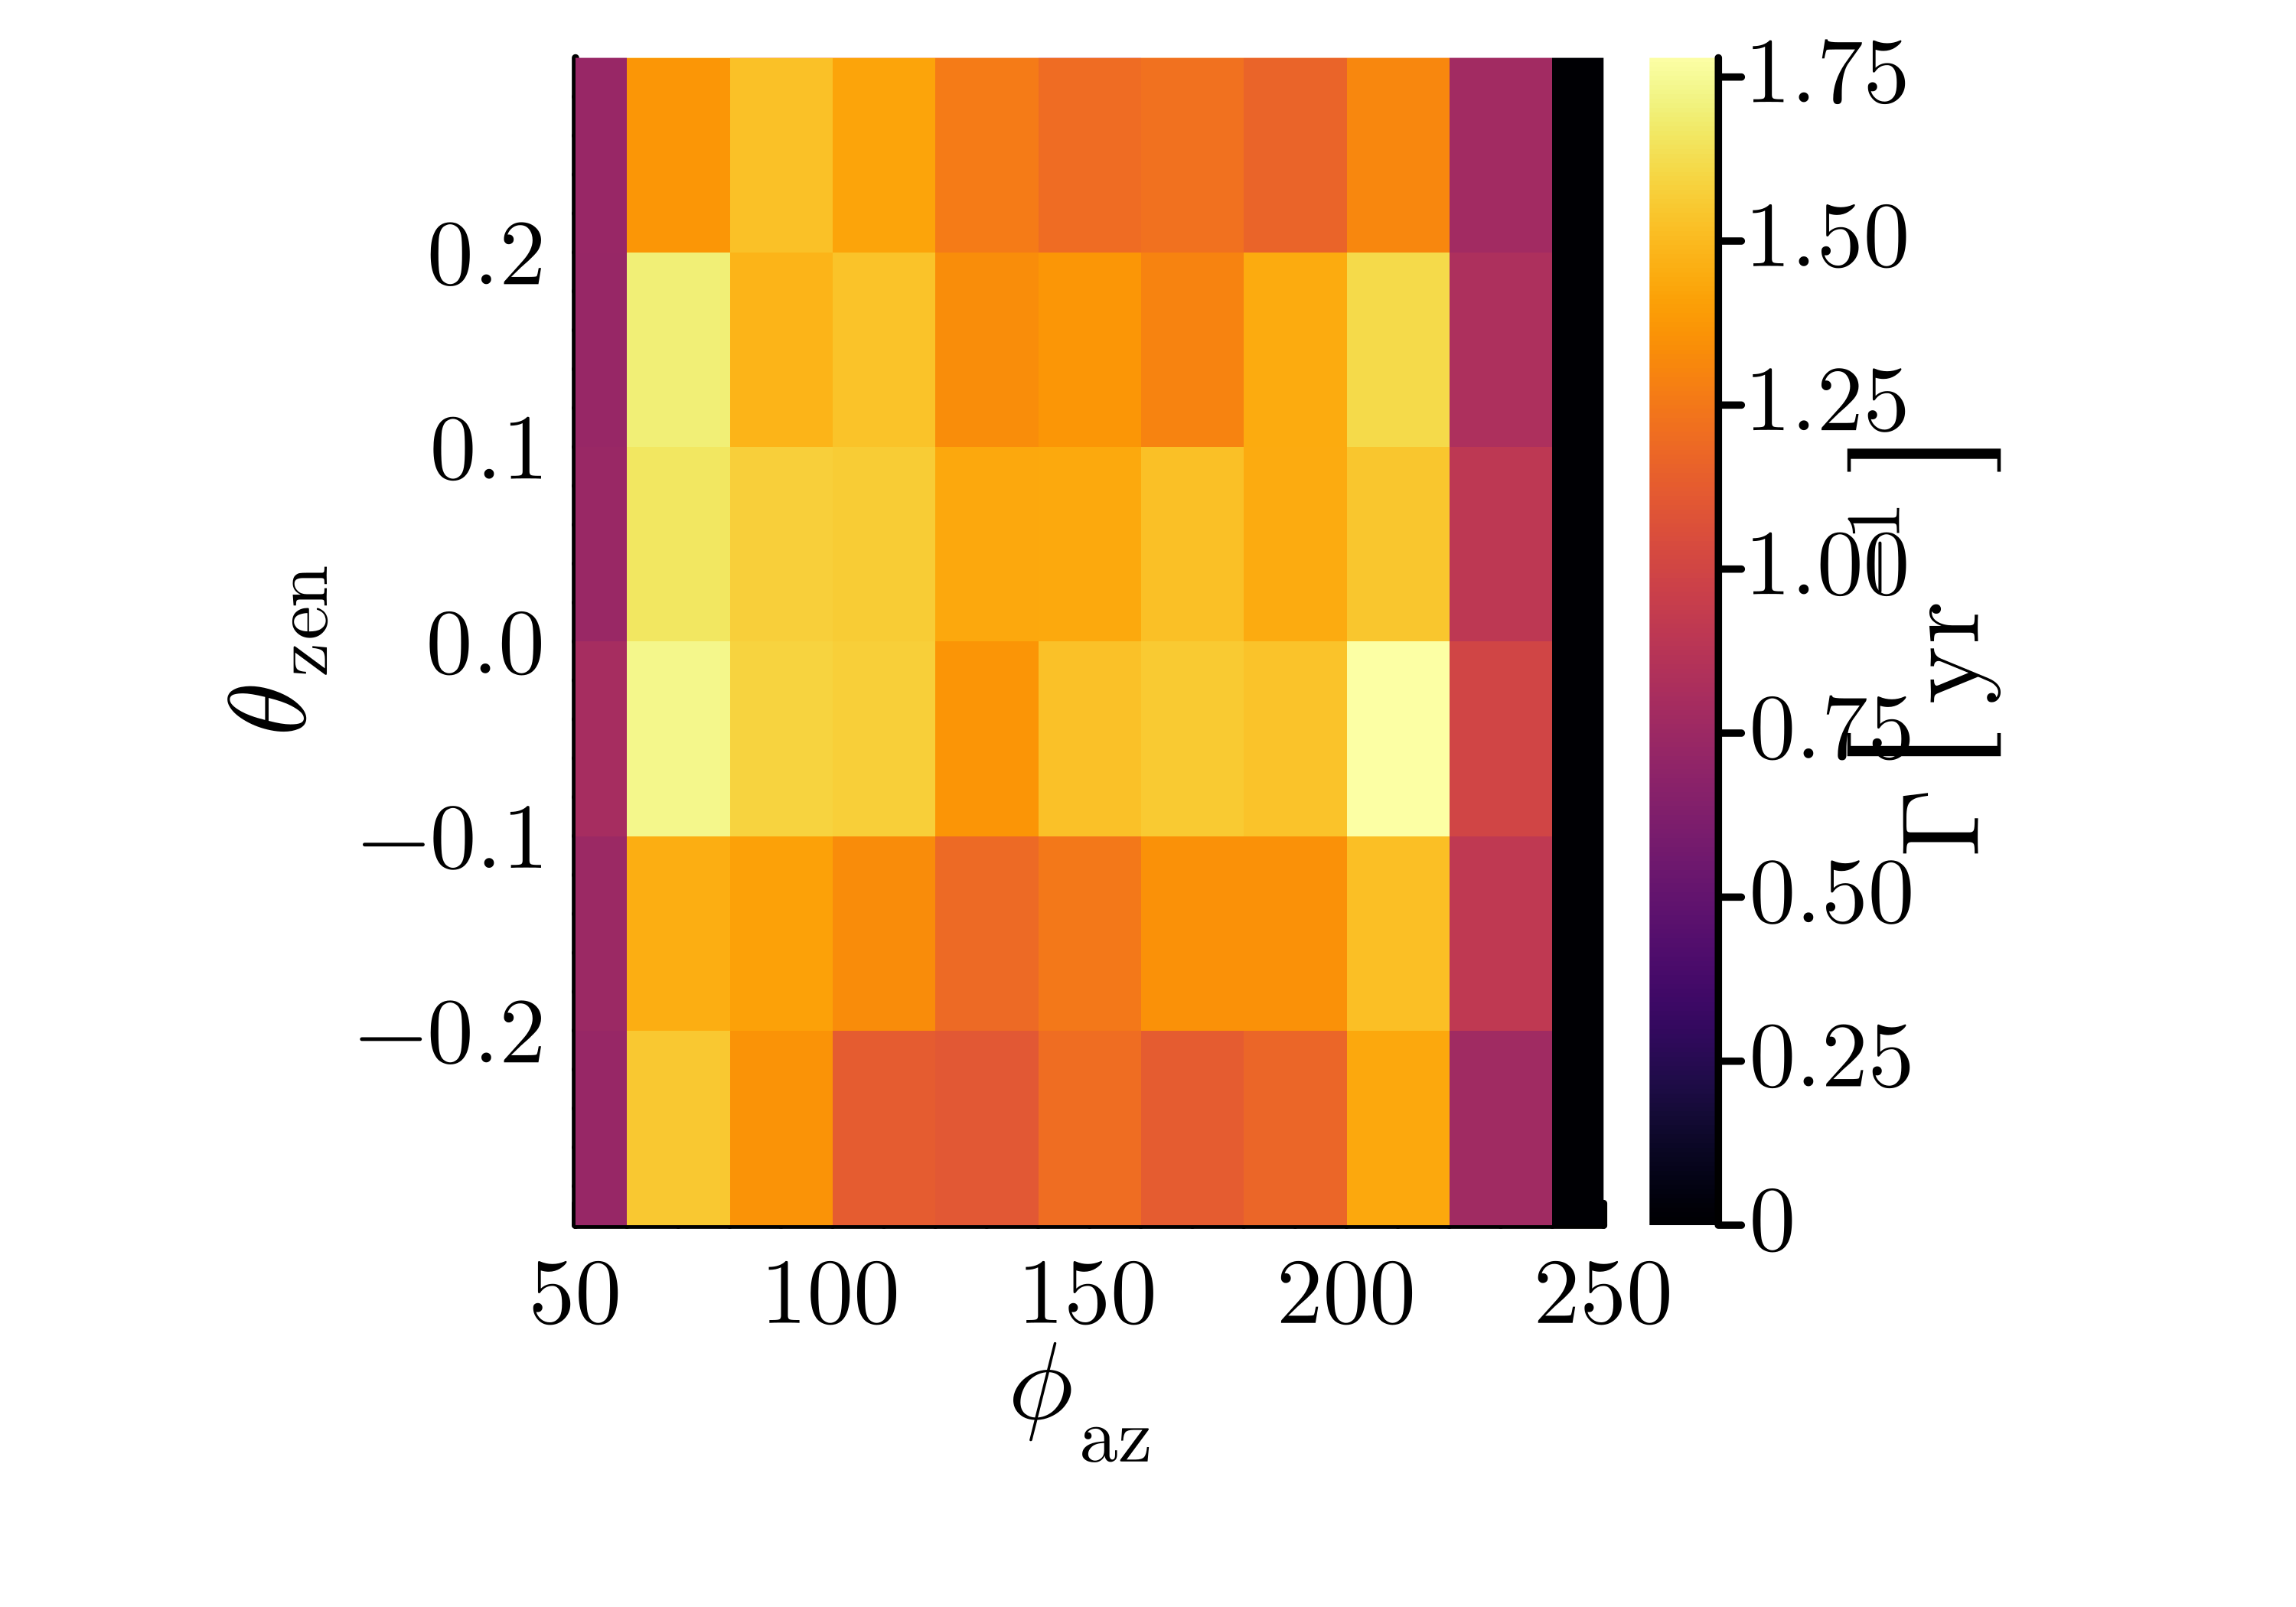

In [40]:
hist_injected = nothing
for (event_dict, sim) in zip(event_dicts, sims)
    run_numbers = parse.(Int, keys(event_dict))
    events = sim["injected_events"][1:maximum(run_numbers)]
    h = make_hist(events, sim, bins, pl)
    if isnothing(hist_injected)
        hist_injected = h.weights / maximum(run_numbers)
    else
        hist_injected .+= h.weights / maximum(run_numbers)
    end
    println(maximum(run_numbers))
end

plt = plot(
    size=(500, 350),
    rightmargin=1cm,
    xlabel=L"\phi_{\mathrm{az}}",
    ylabel=L"\theta_{\mathrm{zen}}",
    xlims=(50, 250),
    ylims=(-0.3, 0.3),
)

heatmap!(
    plt,
    rad2deg.(bins[2]),
    bins[1],
    hist_injected * 10^7.5 * units.second,
    colorbar_title=L"\Gamma~\left[\mathrm{yr}^{-1}\right]",
    thickness_scaling = .6,
)

display(plt)

## Make a plot of all events on which we ran CORSIKA

69409
443011
99912


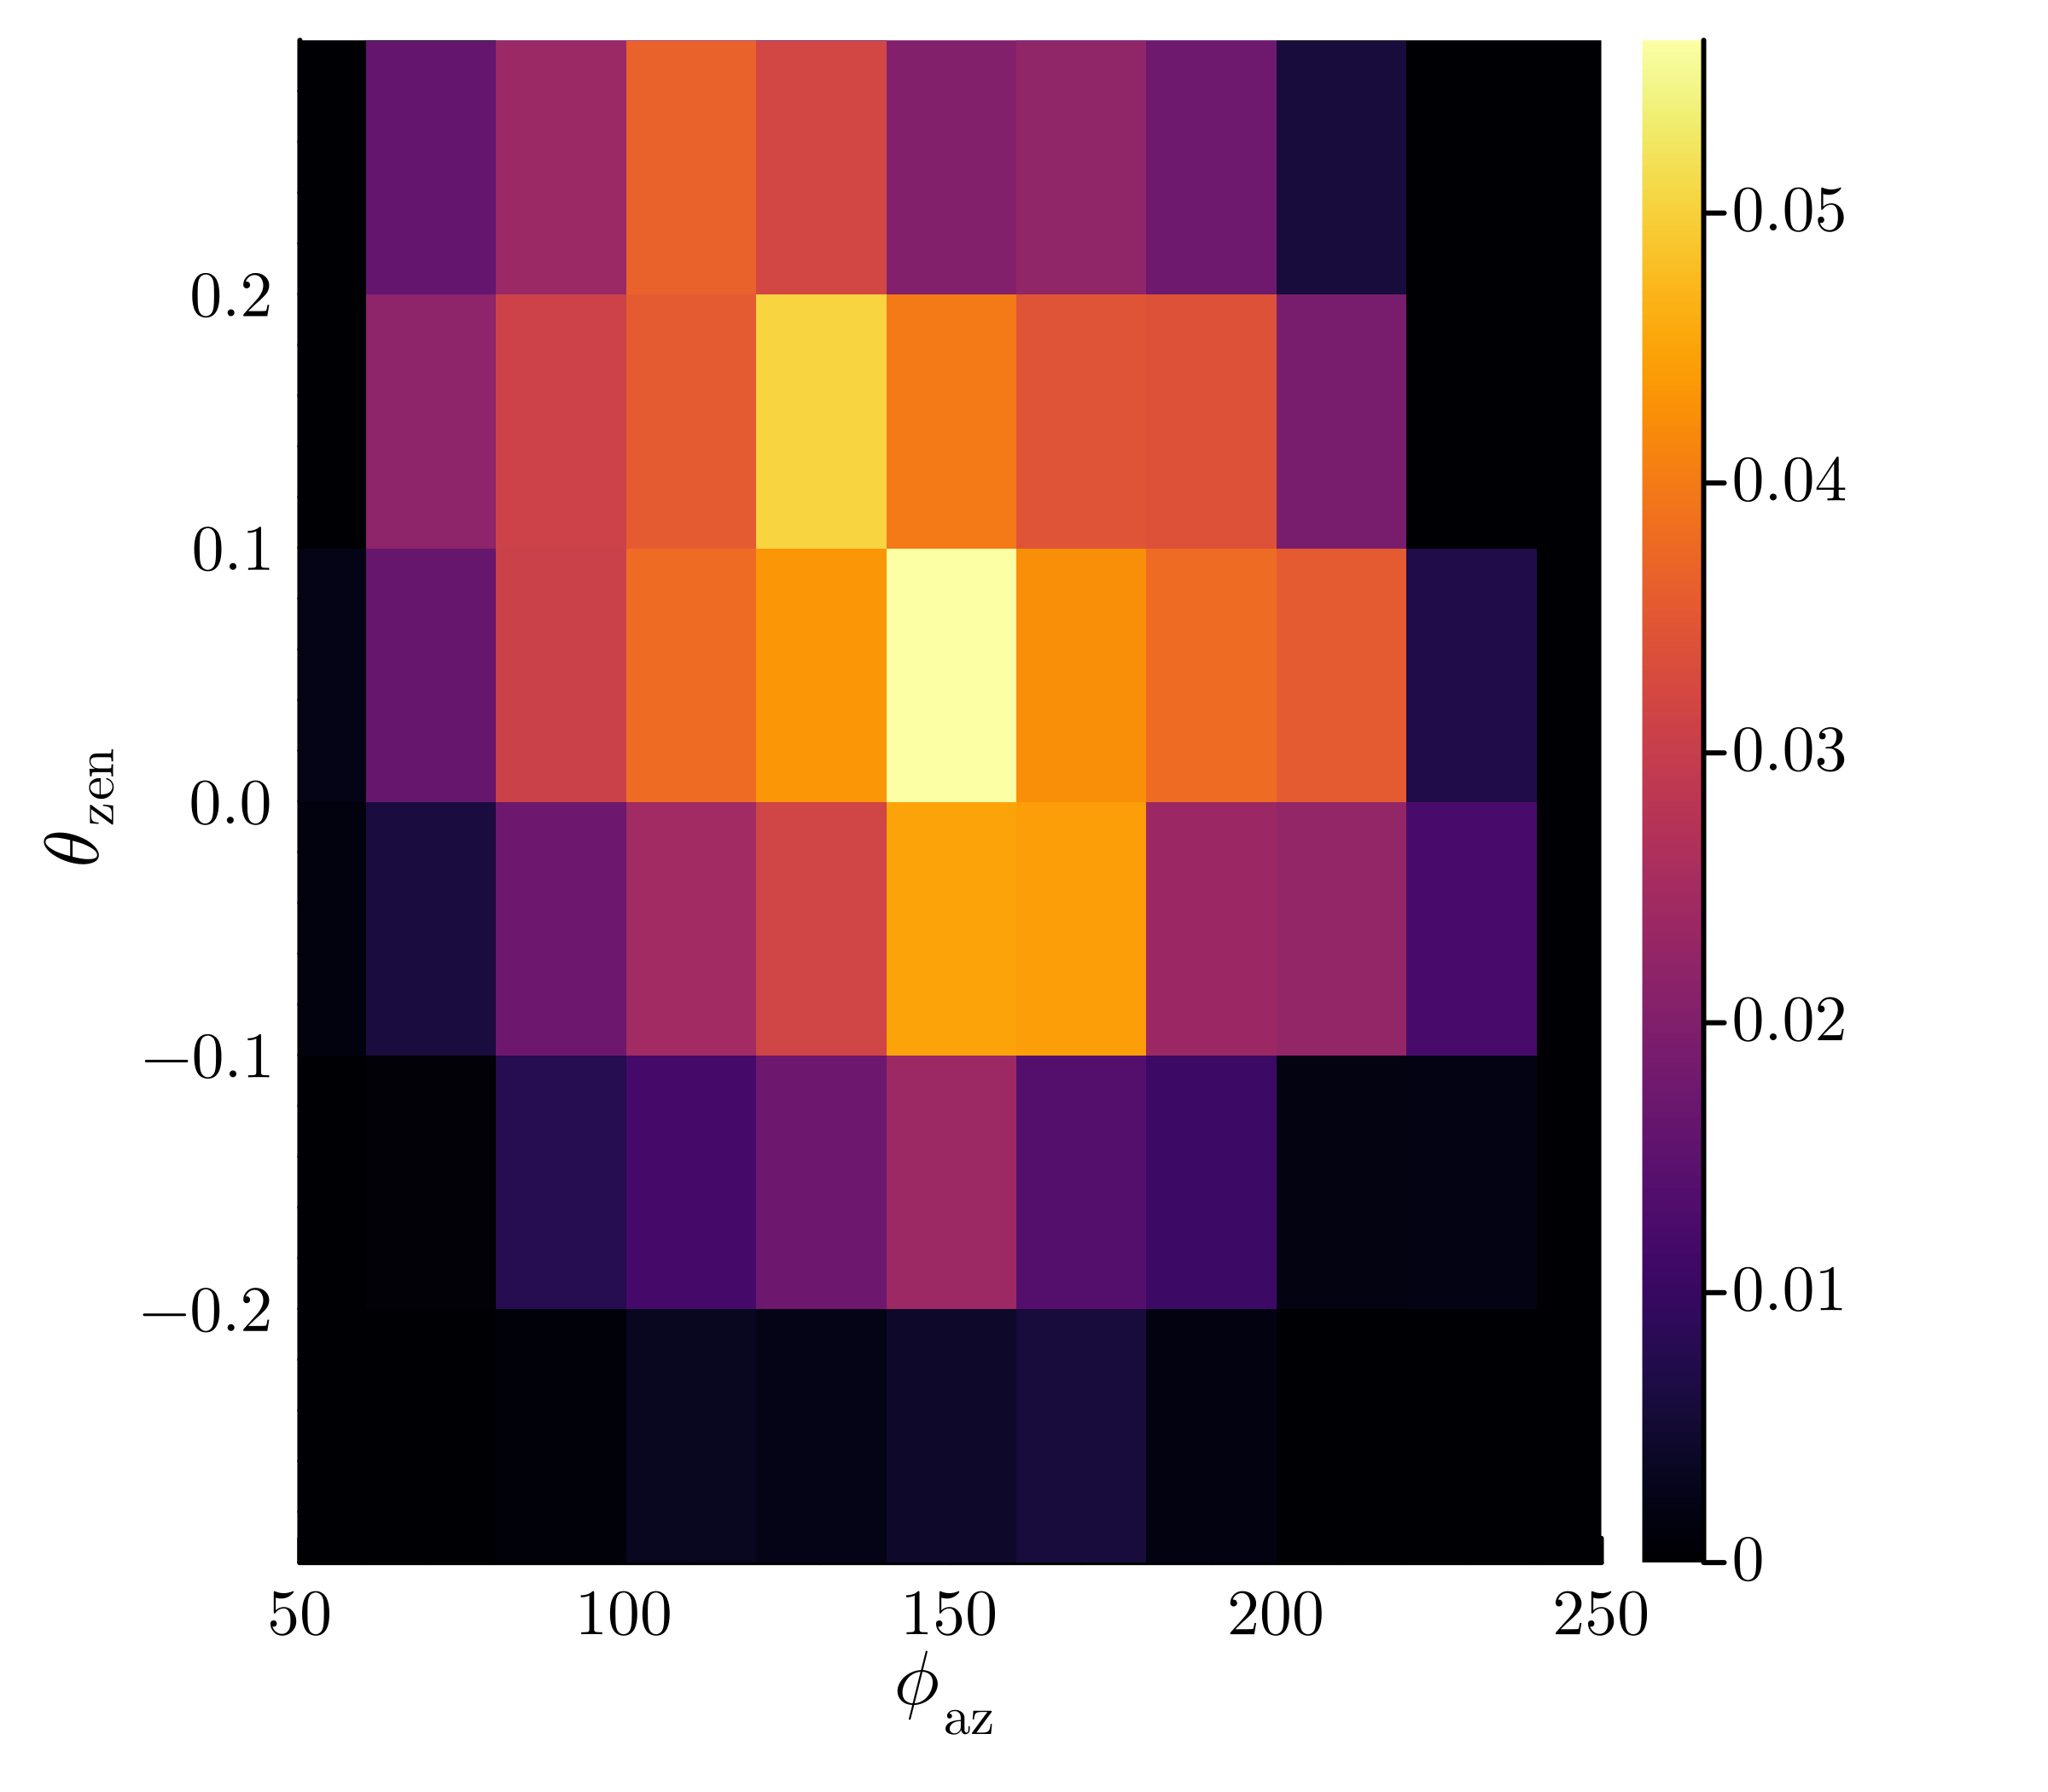

In [35]:
hist_sdc = nothing
for (event_dict, sim) in zip(event_dicts, sims)
    run_numbers = parse.(Int, keys(event_dict))
    events = sim["injected_events"][run_numbers]
    h = make_hist(events, sim, bins, pl)
    if isnothing(hist_sdc)
        hist_sdc = h.weights / maximum(run_numbers)
    else
        hist_sdc .+= h.weights / maximum(run_numbers)
    end
    println(maximum(run_numbers))
end

plt = plot(
    size=(400, 350),
    rightmargin=1cm,
    xlabel=L"\phi_{\mathrm{az}}",
    ylabel=L"\theta_{\mathrm{zen}}",
    xlims=(50, 250),
    ylims=(-0.3, 0.3)
)

heatmap!(
    plt,
    rad2deg.(bins[2]),
    bins[1],
    hist_sdc * 10^7.5 * units.second
)

display(plt)

## Make a plot fo all events that triggered

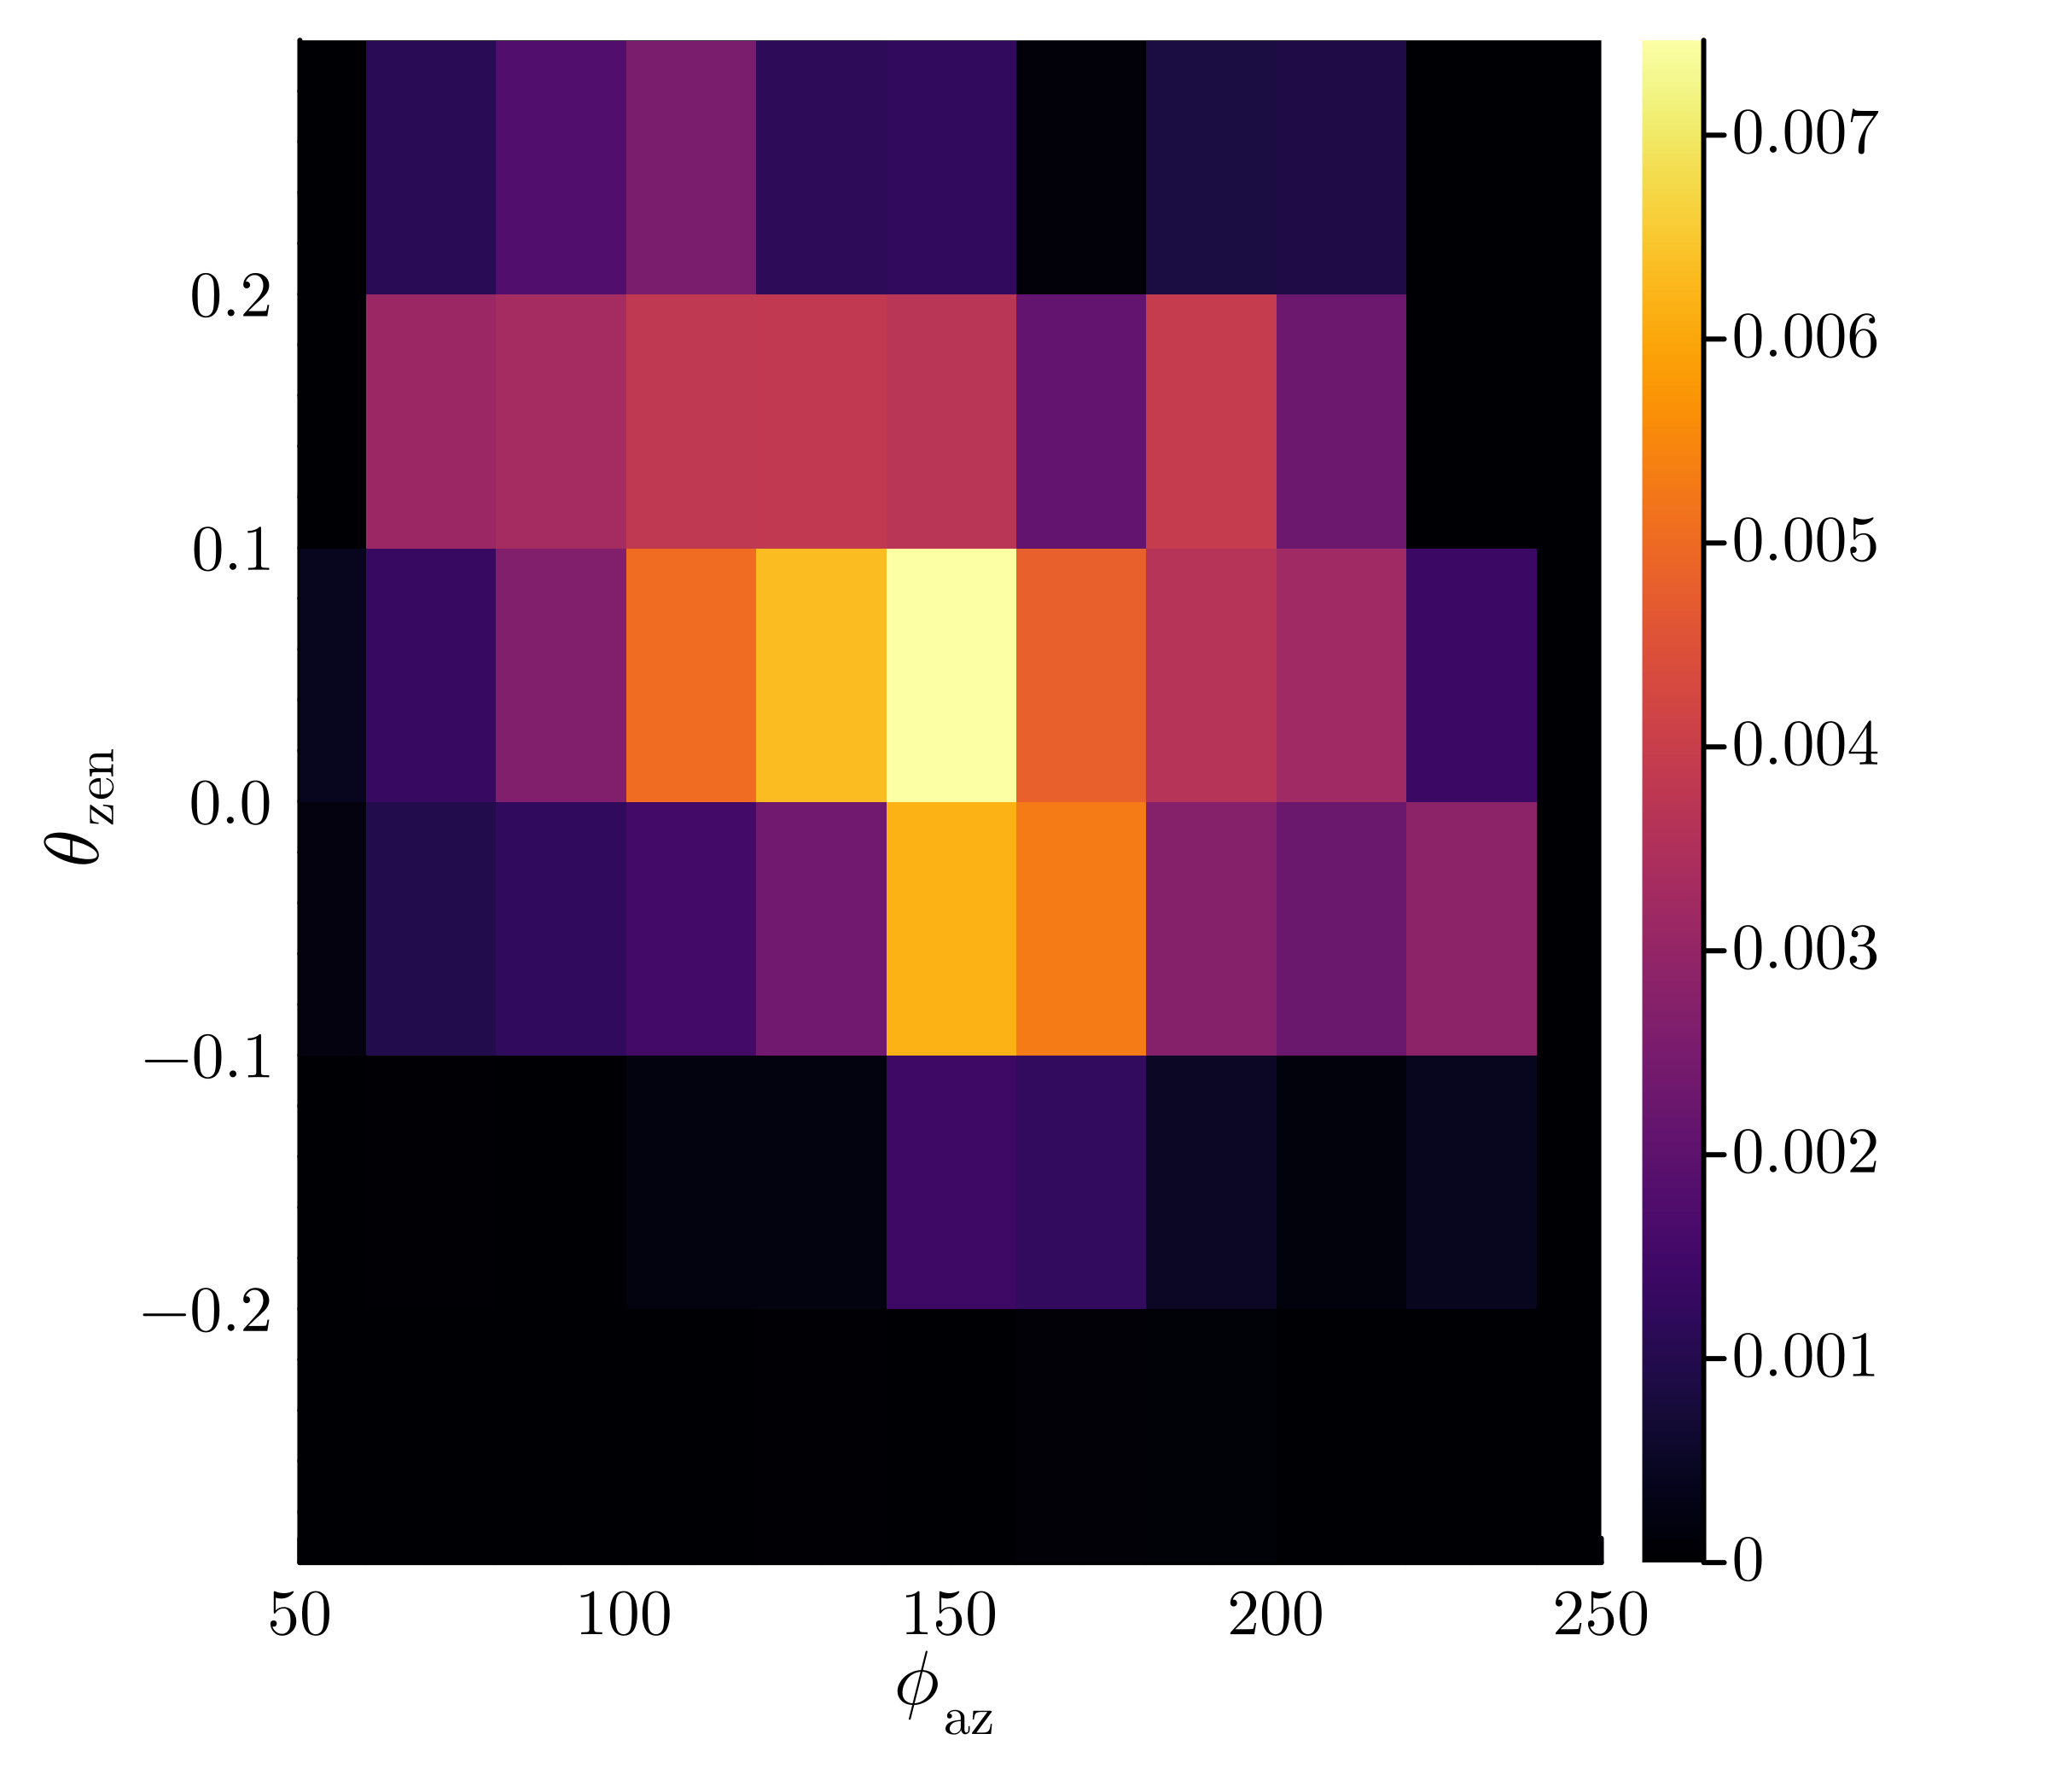

In [37]:
hist_triggered = nothing

conditions = [has_triggered]

for (event_dict, sim) in zip(event_dicts, sims)
    run_numbers = parse.(Int, keys(event_dict))
    mask = makemask(event_dict, conditions)
    # println(mask)
    events = sim["injected_events"][mask]
    h = make_hist(events, sim, bins, pl)
    
    if isnothing(hist_triggered)
        hist_triggered = h.weights / maximum(run_numbers)
    else
        hist_triggered .+= h.weights / maximum(run_numbers)
    end
end

plt = plot(
    size=(400, 350),
    rightmargin=1cm,
    xlabel=L"\phi_{\mathrm{az}}",
    ylabel=L"\theta_{\mathrm{zen}}",
    xlims=(50, 250),
    ylims=(-0.3, 0.3)
)

heatmap!(
    plt,
    rad2deg.(bins[2]),
    bins[1],
    hist_triggered * 10^7.5 * units.second
)

display(plt)